In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

In [2]:
import os

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [4]:
import nibabel as nib

# Utilities

In [5]:
from scipy.ndimage.interpolation import zoom

# TODO: Does z_factor in combination with mask make sense (because it wasn't included in load_masked_nifti)?
# TODO: If the masking operation is to performance intenstive, move it to the gpu via pytorch.
def load_nifti(file_path, mask=None, z_factor=None, remove_nan=True):
    img = nib.load(file_path)
    struct_arr = np.array(img.get_data())#.astype(np.int16)
    #print(struct_arr)
    #if remove_nan:
        #struct_arr = np.nan_to_num(struct_arr)#.nan_to_num(copy=False)
    if mask is not None:
        # TODO: Maybe use numpy's masked array here? Check out if it is faster.
        struct_arr *= mask
    if z_factor is not None:
        struct_arr = np.around(zoom(struct_arr, z_factor), 0)
    
    return struct_arr

struct_arr = load_nifti('data/adni-sample/AD_0003_wT1.nii')

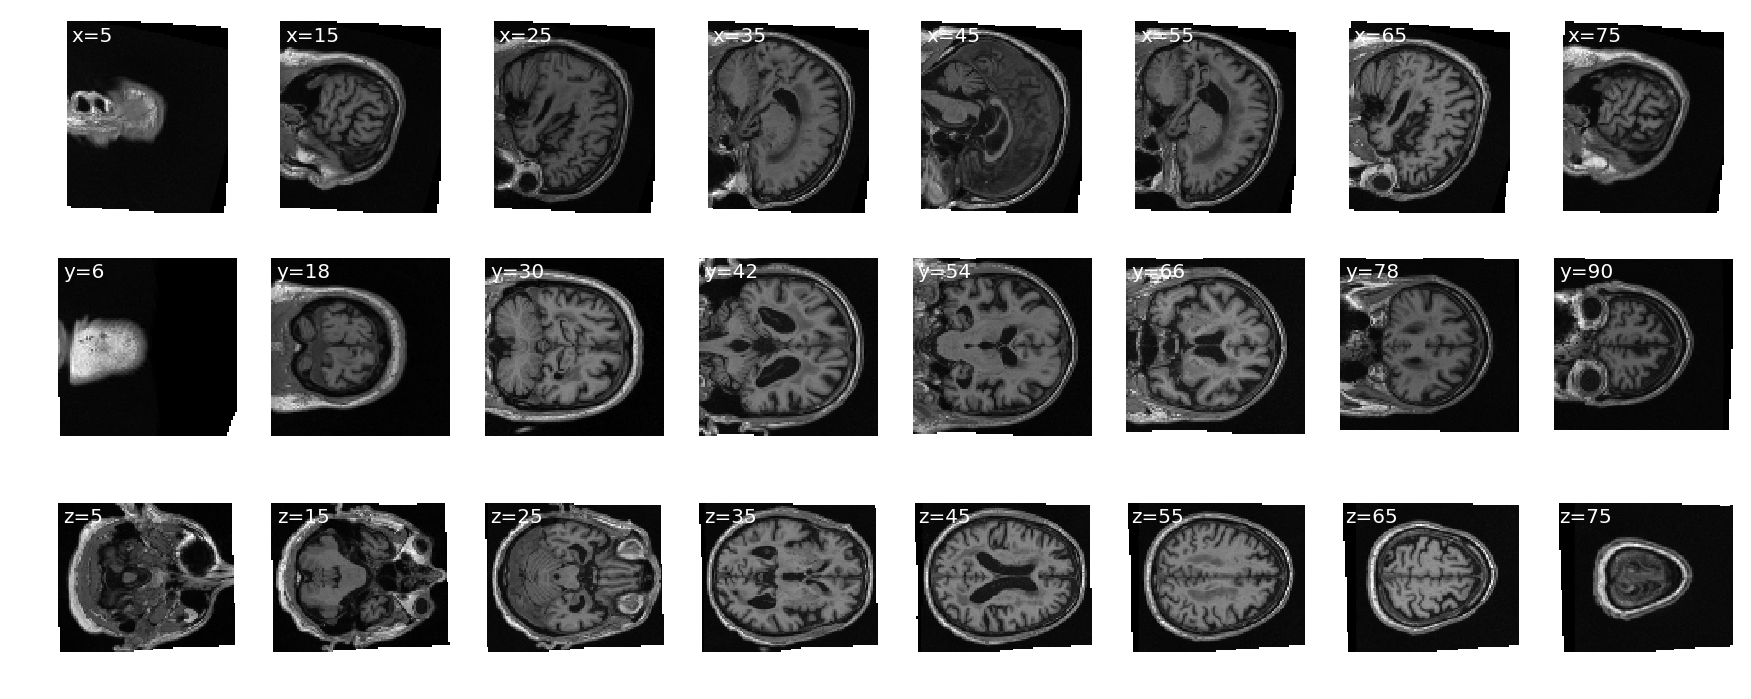

In [6]:
# Make a transparent colormap. See https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap


# Choose colormap
cmap = plt.cm.Reds

# Get the colormap colors
alpha_cmap = cmap(np.arange(cmap.N))

# Set alpha
alpha_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
alpha_cmap = mpl.colors.ListedColormap(alpha_cmap)


# TODO: Calculating the slice numbers gives index error for some values of num_slices.
# TODO: Show figure colorbar.
# TODO: Calculate vmin and vmax automatically, maybe by log-scaling the overlay.

def plot_slices(struct_arr, num_slices=10, overlay=None, overlay_vmin=0, overlay_vmax=0.005):
    fig, axes = plt.subplots(3, 8, figsize=(15, 6))
    
    #if channels_first:
    #    dimensions = struct_arr.shape[1:]
    #else:
    #    dimensions = struct_arr.shape[:-1]
        
    dimensions = struct_arr.shape
    dimensions = np.asarray(dimensions)
    #print(dimensions)
    intervals = dimensions / (num_slices - 1)
    #print(intervals)
    
    
    
    def plot_slice(arr_slice, i_slice, dimension_label, ax):
        plt.sca(ax)
        plt.axis('off')
        plt.imshow(arr_slice, cmap='gray', interpolation=None)
        plt.text(0.03, 0.97, '{}={}'.format(dimension_label, i_slice), color='white', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
        
    
    for i, ax in enumerate(axes[0]):
        i_slice = int(intervals[0] / 2 + i * intervals[0])
        #if channels_first:
        #    arr_slice = struct_arr[0, i_slice, :, :]
        #else:
        arr_slice = struct_arr[i_slice, :, :]
        plot_slice(arr_slice, i_slice, 'x', ax)
        
        if overlay is not None:
            plt.imshow(overlay[i_slice, :, :], cmap=alpha_cmap, vmin=overlay_vmin, vmax=overlay_vmax, interpolation=None)
            #plt.colorbar()
            
    for i, ax in enumerate(axes[1]):
        i_slice = int(intervals[1] / 2 + i * intervals[1])
        #if channels_first:
        #    arr_slice = struct_arr[0, :, i_slice, :]
        #else:
        arr_slice = struct_arr[:, i_slice, :]
        plot_slice(arr_slice, i_slice, 'y', ax)
        
        if overlay is not None:
            plt.imshow(overlay[:, i_slice, :], cmap=alpha_cmap, vmin=overlay_vmin, vmax=overlay_vmax, interpolation=None)
            #plt.colorbar()
    
            
    for i, ax in enumerate(axes[2]):
        i_slice = int(intervals[2] / 2 + i * intervals[2])
        #if channels_first:
        #    arr_slice = struct_arr[0, :, :, i_slice]
        #else:
        arr_slice = struct_arr[:, :, i_slice]
        plot_slice(arr_slice, i_slice, 'z', ax)
        
        if overlay is not None:
            plt.imshow(overlay[:, :, i_slice], cmap=alpha_cmap, vmin=overlay_vmin, vmax=overlay_vmax, interpolation=None)
            #plt.colorbar()
            
plot_slices(struct_arr)#, channels_first=False)

In [7]:
plot_slices(X_test_torch.numpy()[0, 0], overlay=relevance_map[0])

NameError: name 'X_test_torch' is not defined

# Explanation methods on 2D images

## DEPRECATED: Train MNIST network

In [175]:
batch_size = 64
test_batch_size = 1000
lr = 0.01
momentum = 0.5
epochs = 3
log_interval = 10

In [176]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transform), 
                                           batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train=False, transform=transform), 
                                          batch_size=test_batch_size, shuffle=True)

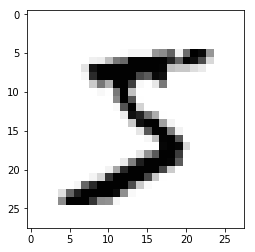

In [177]:
plt.imshow(train_loader.dataset[0][0][0].numpy(), cmap='Greys')

In [178]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        #self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        #self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        #self.fc1 = nn.Linear(320, 50)
        #self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        #x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [179]:
model = Net()
#if args.cuda:
#    model.cuda()

In [180]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [181]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #if args.cuda:
        #    data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
            
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #if args.cuda:
        #    data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [182]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.352602
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.072731
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.806813
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.518186
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.394616
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.194235
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.933826
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.304102
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.003180
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.785011
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.870147
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.743269
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.901443
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.794177
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.852386
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.797313
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.656861
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.644194
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.551758
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.753572
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.168745
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.195384
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.218596
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.437750
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.281969
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.182927
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.211446
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.280850
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.302054
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.386584
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.401711
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.258016
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.269238
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.136084
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.435104
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.425087
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.242533
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.333421
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.196501
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.191313


## Use a model pretrained on ImageNet

In [450]:
model = models.alexnet(pretrained=True)
#model = models.inception_v3(pretrained=True)  # raises an error when predicting
#model = models.vgg19_bn(pretrained=True)

In [458]:
list(list(model.children())[0].children())

[Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1)),
 Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1)),
 Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))]

In [4]:
valdir = 'data/images'

image_means = np.array([0.485, 0.456, 0.406])
image_stds = np.array([0.229, 0.224, 0.225])

normalize = transforms.Normalize(mean=image_means, std=image_stds)

val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=64, shuffle=False,
        num_workers=1, pin_memory=True)

In [5]:
def image_tensor_to_rgb(image_tensor):
    '''Convert a normalized image tensor to an RGB array (that can be displayed via pyplot.imshow).'''
    image = image_tensor.numpy() * image_stds.reshape(3, 1, 1) + image_means.reshape(3, 1, 1)
    image = image.transpose(1, 2, 0)
    return image

def get_image(index):
    image_tensor = val_loader.dataset[index][0]
    return image_tensor_to_rgb(image_tensor), image_tensor

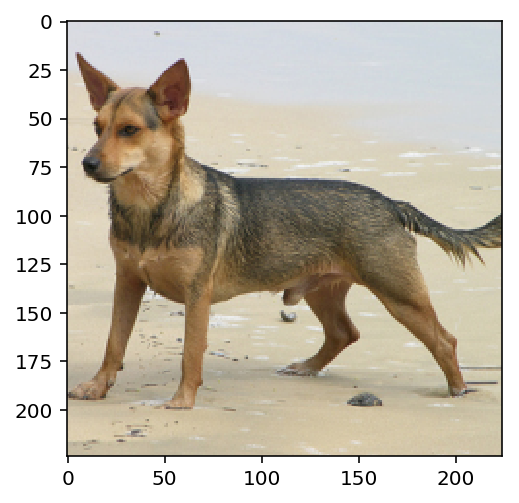

In [6]:
plt.imshow(get_image(0)[0])

In [7]:
# To get the same results as in pytorch-cnn-visualizations (https://github.com/utkuozbulak/pytorch-cnn-visualizations),
# set a fixed target class and do `postprocess=None`.

def sensitivity_analysis(model, image_tensor, target=None, postprocess='abs'):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    
    model.eval()
    output = model(X)
    output_class = output.max(1)[1].data.numpy()[0]
    print('Image was classified as:', output_class)
    
    model.zero_grad()
    one_hot_output = torch.zeros(output.size())
    if target is None:
        one_hot_output[0, output_class] = 1
    else:
        one_hot_output[0, target] = 1
    output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
    else:
        raise ValueError()
    
def taylor_decomposition(model, image_tensor, target=None):
    relevance_map = sensitivity_analysis(model, image_tensor, target=target)
    
    try:
        image_tensor = image_tensor.numpy()  # if it's a pytorch tensor
    except AttributeError:
        image_tensor = np.asarray(image_tensor)  # if it's a list or anything else
    
    return relevance_map * image_tensor.max(axis=0)  # TODO: How to deal with the several color channels of the image?

In [8]:
def guided_backprop(model, image_tensor, target=None, postprocess='abs'):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        for pos, module in model.features._modules.items():
            if isinstance(module, nn.ReLU):
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target=target, postprocess=postprocess)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

In [9]:
from pytorch_cnn_visualizations.vanilla_backprop import VanillaBackprop
from pytorch_cnn_visualizations.guided_backprop import GuidedBackprop
from pytorch_cnn_visualizations.misc_functions import convert_to_grayscale

Image was classified as: 232
Image was classified as: 232
Image was classified as: 232
Image was classified as: 249
Image was classified as: 249
Image was classified as: 249
Image was classified as: 947
Image was classified as: 947
Image was classified as: 947
Image was classified as: 27
Image was classified as: 27
Image was classified as: 27


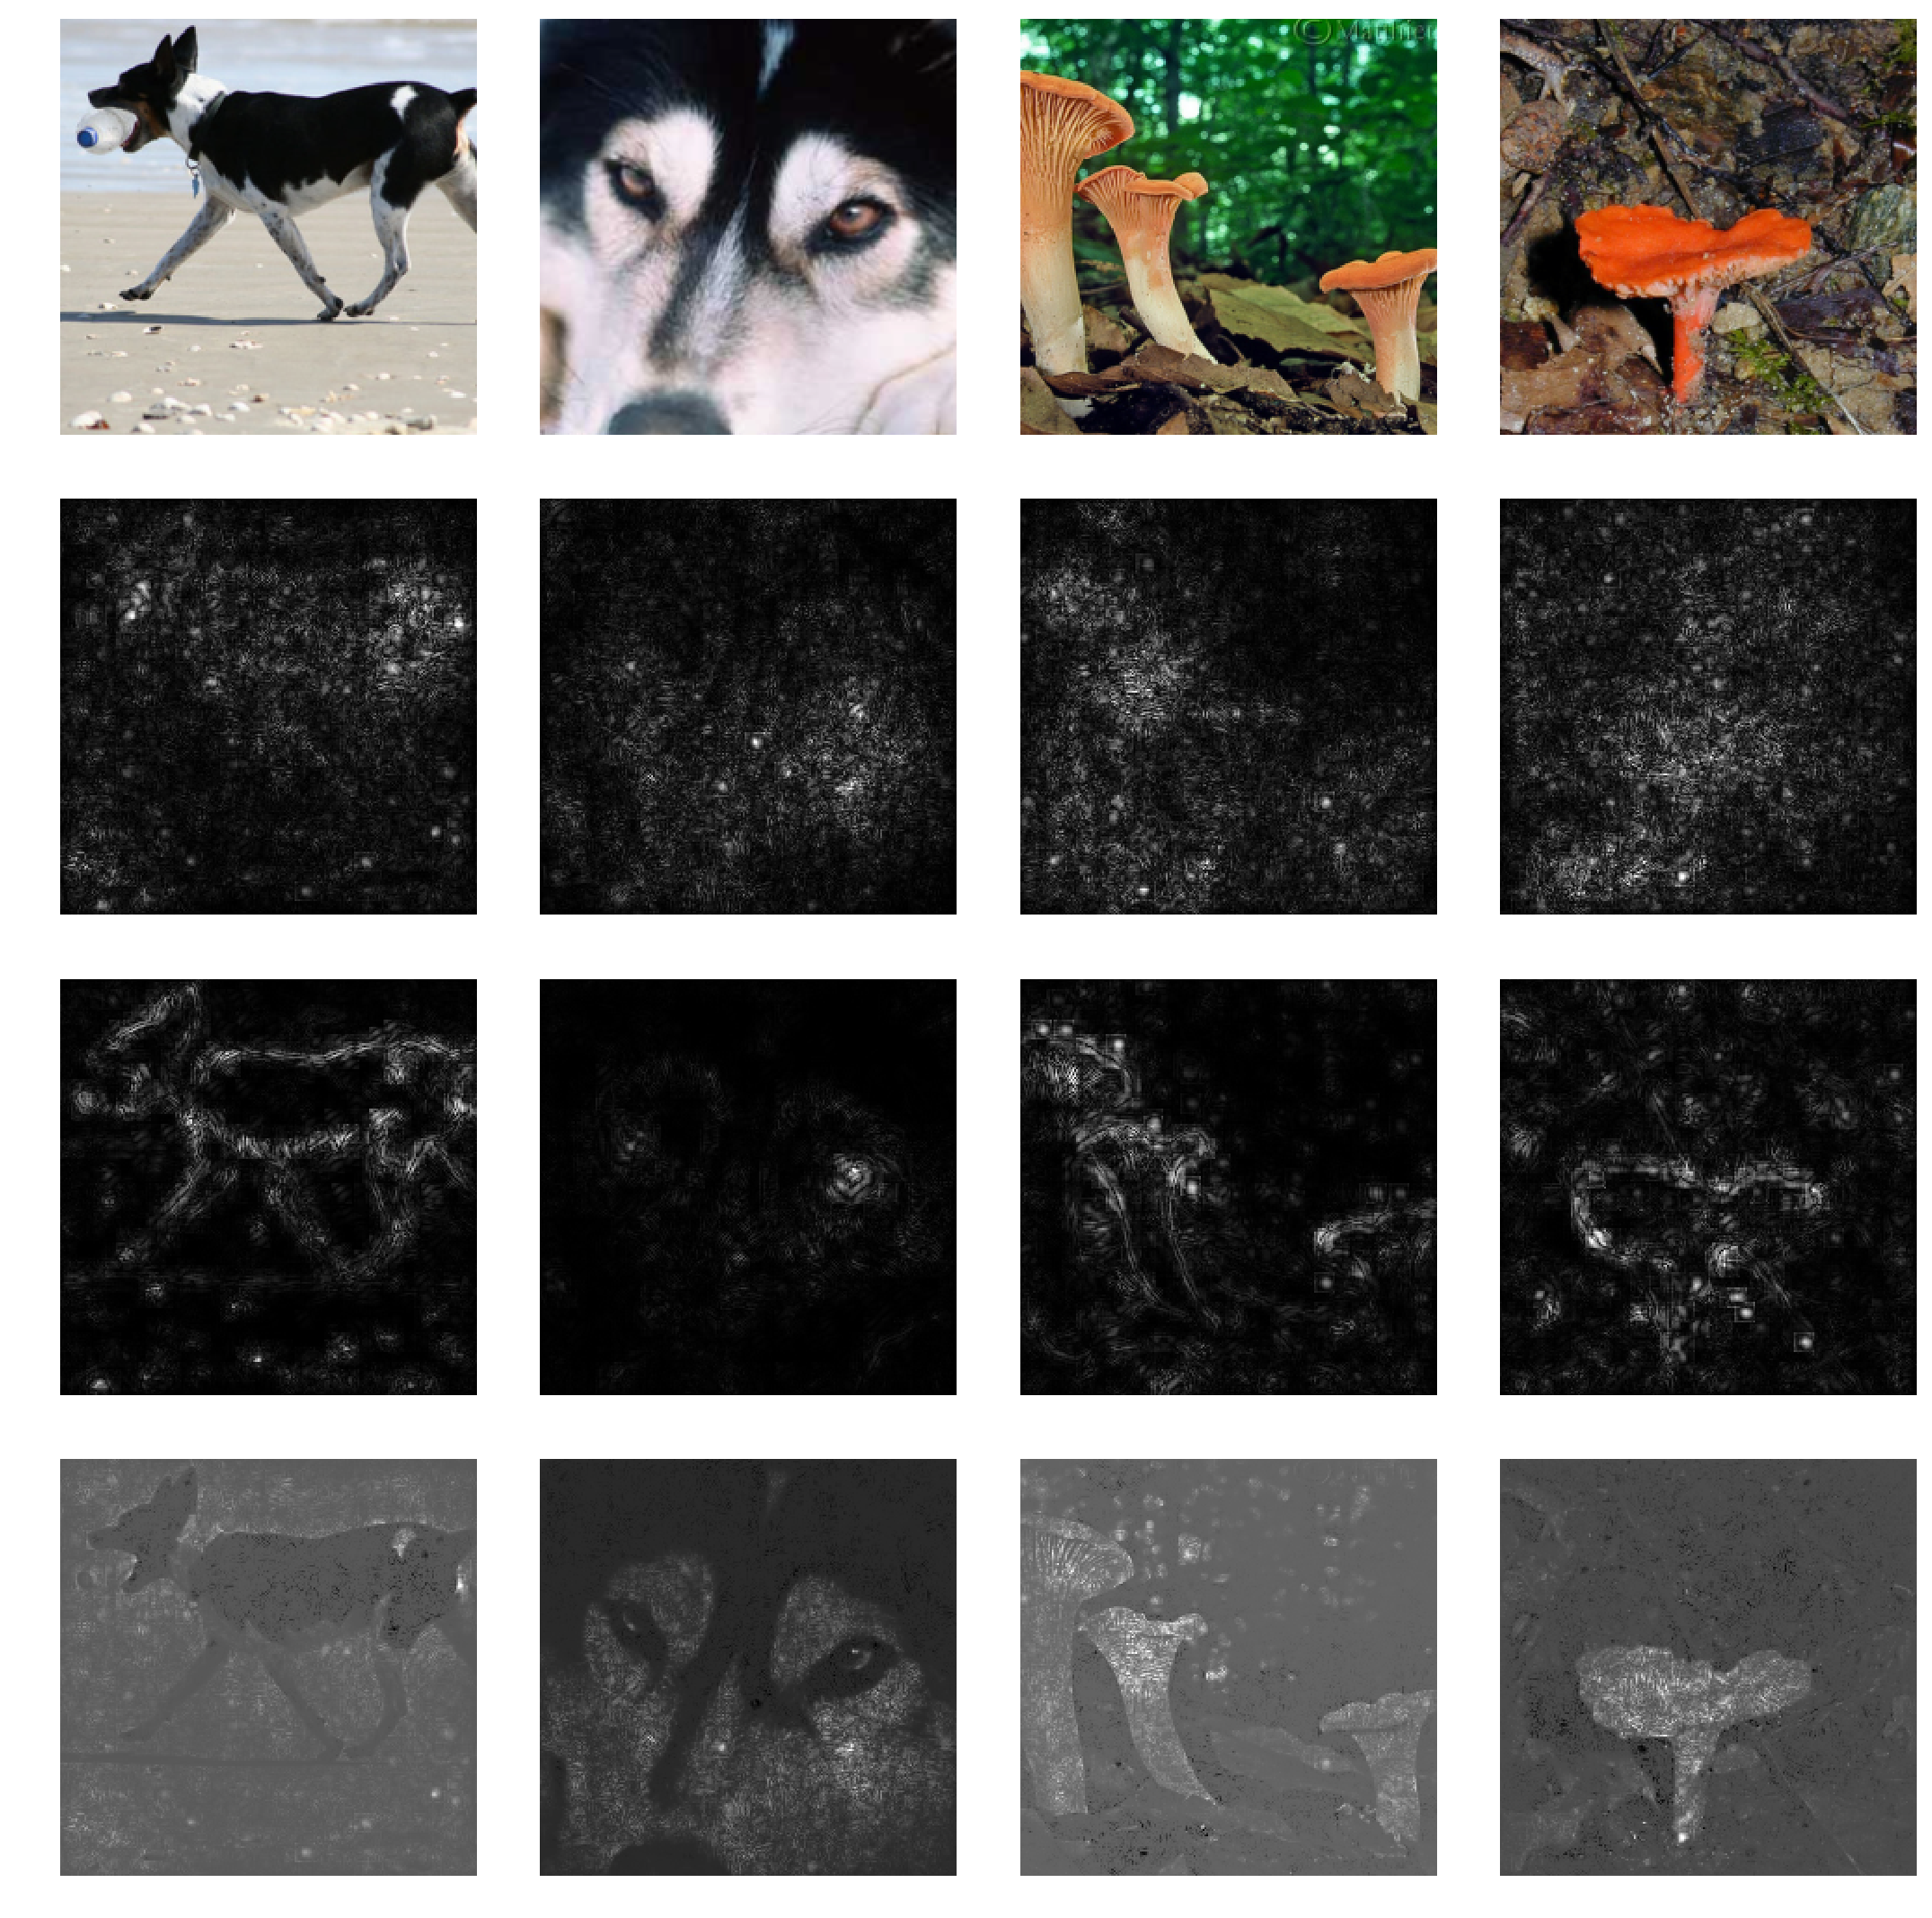

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

offset = 2

for i, vertical_axes in enumerate(axes.T):
    image, image_tensor = get_image(i+offset)
    
    plt.sca(vertical_axes[0])
    plt.axis('off')
    plt.imshow(image)
    
    plt.sca(vertical_axes[1])
    plt.axis('off')
    plt.imshow(sensitivity_analysis(model, image_tensor, postprocess='abs').max(0), cmap='Greys_r')
    
    #plt.sca(vertical_axes[2])
    #plt.axis('off')
    #vbp = VanillaBackprop(model, Variable(image_tensor[None], requires_grad=True), 227)
    #vbp_heatmap = vbp.generate_gradients()
    #plt.imshow(vbp_heatmap.max(0), cmap='Greys_r')
    
    plt.sca(vertical_axes[2])
    plt.axis('off')
    # TODO: Investigate why my methods are different from the package.
    # Possible reasons: target class, true one-hot vector, abs postprocessing, gradient w.r.t parameters vs input
    plt.imshow(guided_backprop(model, image_tensor, postprocess='abs').max(0), cmap='Greys_r')
    
    #plt.sca(vertical_axes[4])
    #plt.axis('off')
    # TODO: Target class.
    #gbp = GuidedBackprop(model, Variable(image_tensor[None], requires_grad=True), 227)
    #gbp_heatmap = gbp.generate_gradients()
    #plt.imshow(gbp_heatmap.max(0), cmap='Greys_r')
    #gbp.unhook()
    
    plt.sca(vertical_axes[3])
    plt.axis('off')
    plt.imshow(taylor_decomposition(model, image_tensor).max(0), cmap='Greys_r')

plt.tight_layout()

- 1st row: Image
- 2nd row: Vanilla Backprop (mine)
- 3th row: Guided Backprop (mine)
- 4th row: Taylor Decomposition (mine)

In [ ]:
# Make a transparent colormap. See https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap

# Choose colormap
reds = plt.cm.Reds

# Get the colormap colors
alpha_reds = cmap(np.arange(cmap.N))

# Set alpha
alpha_reds[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
alpha_reds = mpl.colors.ListedColormap(alpha_reds)

# Classification Networks for ADNI

In [7]:
# Local
data_dir = 'data/adni-sample'

# Remote (Ubuntu)
#data_dir = '/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

# Remote (Mac)
#data_dir = '/Volumes/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

## Load keras network from Fabian

In [8]:

def preprocess_img(x, mean, std):
    x = (x - mean) / (std + e)
    return x

def deprocess_img(x, mean, std):
    x = x * std + mean
    return x

def load_nifti(file_path, z_factor=None):
    img = nib.load(file_path)
    struct_arr = img.get_data().astype(np.int16)
    if z_factor is not None:
        struct_arr = np.around(zoom(struct_arr, z_factor), 0)
    return struct_arr

def load_masked_nifti(file_path, mask):#, sess, scan_pl, mask_pl):
    #import tensorflow as tf
    struct_arr = load_nifti(file_path)
    struct_arr[np.where(np.isnan(struct_arr))] = 0

    #c = tf.multiply(scan_pl, mask_pl)
    #res = sess.run(c, feed_dict={scan_pl: struct_arr,
    #                            mask_pl: mask})
    res = struct_arr * mask
    return res

In [9]:
# TODO: Needs to be /Volumes/analysis on Mac and /analysis on Linux.
FOLDER = data_dir
#FOLDER = '/Volumes/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'
is2D = False
#z_slice = 40
e = 1e-6

In [10]:
import tensorflow as tf
import os

def make_dataset(mask=None, remove_nan=True):
    X = np.empty(shape=(98, 91, 109, 91, 1), dtype=np.float32)
    y = np.empty(shape=(98, 1), dtype=np.int8)
    i = 0
    
    #with tf.Session() as sess:
        #scan_pl = tf.placeholder(tf.float32, shape=(91, 109, 91))
        #mask_pl = tf.placeholder(tf.float32, shape=(91, 109, 91))
    for fn in os.listdir(FOLDER):
        if fn.endswith('.nii'):
            if mask is None:
                struct_arr = load_nifti(FOLDER + '/' + fn)
            else:
                struct_arr = load_masked_nifti(FOLDER + '/' + fn, mask)#, sess, scan_pl, mask_pl)
            if remove_nan:
                struct_arr[np.where(np.isnan(struct_arr))] = 0  
            X[i,:,:,:,0] = struct_arr
            y[i] = 1 if fn.startswith('AD') else 0

            i += 1

    #np.random.seed = 55
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]

    # Take specific z_slice only when using 2-D
    if is2D:
        X = X[:,:,:,z_slice,:]

    X_train = X[0:60]  # 0:60
    y_train = y[0:60]

    X_val = X[60:79]  # 60:79
    y_val = y[60:79]

    X_test = X[79:98]  # 79:98
    y_test = y[79:98]

    # Normalize    
    pixel_mean = np.mean(X_train)
    pixel_std = np.std(X_train, axis=0)

    # TODO: Why isn't this normalized to 0 mean?
    X_train = (X_train) / (pixel_std + e)
    X_val = (X_val) / (pixel_std + e)
    X_test = (X_test) / (pixel_std + e)
       
    return X_train, X_val, X_test, y_train, y_val, y_test, pixel_mean, pixel_std

In [11]:
mask_filename = 'data/WM_GM_mask.nii.gz'
#plotting.plot_anat(mask_filename)
# TODO: What does z_factor do here?
mask = load_nifti(mask_filename, z_factor=0.75)
mask.shape

/Users/d068730/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(91, 109, 91)

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test, pixel_mean, pixel_std = make_dataset(mask=mask)

In [13]:
X_train.shape, X_train.min(), X_train.max(), X_train.mean(), X_train.std()

((60, 91, 109, 91, 1), 0.0, 7.4031157, 0.28862849, 0.72520882)

In [19]:
model_filename = os.path.join(FOLDER, 'models/model_121217_1.h5')

In [20]:
import keras

Using TensorFlow backend.


In [21]:
model = keras.models.load_model(model_filename)

In [ ]:
#pred_train = model.predict(X_train)
#pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

In [ ]:
np.mean(pred_train.round() == y_train), np.mean(pred_val.round() == y_val), np.mean(pred_test.round() == y_test)

In [ ]:
model.summary()

## Transfer parameters from keras to pytorch model
All parameters (weights and biases of all layers) seem to be transferred correctly, but the pytorch model gives wrong and unreasonable results (i.e. they are not close to 0 or 1 but somewhat random in between). It seems to be an issue with dimension ordering: The keras model above has channels last, while pytorch has channels first. nntransfer does not seem to handle the weight transfer in this situation correctly. The simple example included in the repo also gives wrong results when the channel dimension is different in the model (and the dimensions in the data are of course swapped).

### Example from nntransfer (DEPRECATED)

In [288]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv3d(1, 6, 5)
        self.conv2 = nn.Conv3d(6, 16, 5)
        #self.fc1   = nn.Linear(16*5*5*5, 120)
        #self.fc2   = nn.Linear(120, 84)
        #self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool3d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool3d(out, 2)
        print(out.size())
        out = out.permute(0, 2, 3, 4, 1)
        out = out.contiguous()
        print(out.size())
        out = out.view(out.size(0), -1)
        #out = F.relu(self.fc1(out))
        #out = F.relu(self.fc2(out))
        #out = self.fc3(out)
        return out
    
pytorch_network = LeNet()

In [289]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv3D, MaxPooling3D, Conv2D
K.set_image_data_format('channels_last')


def lenet_keras():

    model = Sequential()
    model.add(Conv3D(6, kernel_size=(5, 5, 5),
                     activation='relu',
                     input_shape=(32,32,32,1),
                     name='conv1'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(16, (5, 5, 5), activation='relu', name='conv2'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    #model.add(Dense(120, activation='relu', name='fc1'))
    #model.add(Dense(84, activation='relu', name='fc2'))
    #model.add(Dense(10, activation=None, name='fc3'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta())
    
    return model
    
keras_network = lenet_keras()

In [290]:
from nn_transfer import transfer
transfer.keras_to_pytorch(keras_network, pytorch_network, flip_filters=False)

Layer names in PyTorch state_dict ['conv1', 'conv2']
Layer names in Keras HDF5 ['conv1', 'conv2', 'flatten_17', 'max_pooling3d_20', 'max_pooling3d_21']


In [291]:
# Create dummy data
data = torch.rand(6,1,32,32, 32)
data_keras = data.numpy().transpose(0, 2, 3, 4, 1)
data_pytorch = Variable(data, requires_grad=False)


In [292]:
data_keras[0].shape

(32, 32, 32, 1)

In [293]:
data_pytorch[0].size()

torch.Size([1, 32, 32, 32])

In [294]:
# Do a forward pass in both frameworks
keras_pred = keras_network.predict(data_keras)
pytorch_pred = pytorch_network(data_pytorch).data.numpy()

torch.Size([6, 16, 5, 5, 5])
torch.Size([6, 5, 5, 5, 16])


In [295]:
keras_pred.shape, pytorch_pred.shape

((6, 2000), (6, 2000))

In [296]:
import numpy as np
np.set_printoptions(threshold=1000)

In [297]:
keras_pred[0, :100]#.transpose(0, 4, 1, 2, 3)[0]

array([ 0.24959783,  0.        ,  0.        ,  0.        ,  0.21287172,
        0.        ,  0.37343282,  0.32151151,  0.45859426,  0.17591476,
        0.        ,  0.        ,  0.36131161,  0.39335451,  0.01074955,
        0.        ,  0.16352226,  0.        ,  0.        ,  0.        ,
        0.25564834,  0.05177277,  0.34612763,  0.30771184,  0.39673814,
        0.19783145,  0.        ,  0.        ,  0.32782769,  0.42706138,
        0.        ,  0.        ,  0.18506847,  0.        ,  0.        ,
        0.        ,  0.24792546,  0.        ,  0.43791938,  0.33867788,
        0.45843372,  0.28396189,  0.        ,  0.        ,  0.34743568,
        0.38683254,  0.        ,  0.        ,  0.1482189 ,  0.        ,
        0.        ,  0.        ,  0.26987636,  0.        ,  0.40121448,
        0.3576887 ,  0.5098089 ,  0.20011321,  0.        ,  0.        ,
        0.37686884,  0.37789044,  0.        ,  0.        ,  0.27024606,
        0.        ,  0.        ,  0.        ,  0.17397453,  0.  

In [298]:
pytorch_pred[0, :100]

array([ 0.24959782,  0.        ,  0.        ,  0.        ,  0.21287155,
        0.        ,  0.37343293,  0.32151139,  0.45859468,  0.17591481,
        0.        ,  0.        ,  0.36131158,  0.39335445,  0.01074957,
        0.        ,  0.16352224,  0.        ,  0.        ,  0.        ,
        0.25564834,  0.05177292,  0.34612745,  0.30771193,  0.39673769,
        0.19783147,  0.        ,  0.        ,  0.32782745,  0.42706123,
        0.        ,  0.        ,  0.18506849,  0.        ,  0.        ,
        0.        ,  0.24792549,  0.        ,  0.43791962,  0.33867797,
        0.45843342,  0.28396183,  0.        ,  0.        ,  0.34743565,
        0.38683248,  0.        ,  0.        ,  0.14821881,  0.        ,
        0.        ,  0.        ,  0.2698763 ,  0.        ,  0.40121463,
        0.3576887 ,  0.50980908,  0.20011337,  0.        ,  0.        ,
        0.37686881,  0.37789017,  0.        ,  0.        ,  0.27024609,
        0.        ,  0.        ,  0.        ,  0.17397463,  0.  

### ADNI model

In [464]:
class ClassificationModel3D(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 64, 3)
        self.Conv_2 = nn.Conv3d(64, 64, 3)
        self.Conv_3 = nn.Conv3d(64, 64, 3)
        self.Conv_4 = nn.Conv3d(64, 64, 3)
        self.dense_1 = nn.Linear(128, 1)
        self.elu = nn.ELU()
        
    def forward(self, x):
        x = self.elu(self.Conv_1(x))  # TODO: Probably need relu for guided backprop!
        x = F.max_pool3d(x, 3)
        #plot_slices(x[0])
        x = self.elu(self.Conv_2(x))
        x = F.max_pool3d(x, 3)
        x = self.elu(self.Conv_3(x))
        x = self.elu(self.Conv_4(x))
        x = F.max_pool3d(x, 3)
        
        # The permute operation converts the tensor from channels_first to channels_last format.
        # This is required to transfer a keras model that uses channels_last (pytorch uses channels_first by default).
        # Otherwise, the Flatten layer in keras and the view operation here output different values.
        # Remove this if the original keras network uses channels_first.
        x = x.permute(0, 2, 3, 4, 1).contiguous()
        
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.dense_1(x))
        return x
    
pytorch_model = ClassificationModel3D()

In [465]:
list(pytorch_model.children())

[Conv3d (1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1)),
 Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1)),
 Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1)),
 Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1)),
 Linear(in_features=128, out_features=1),
 ELU(alpha=1.0)]

In [466]:
from nn_transfer import transfer

In [467]:
transfer.keras_to_pytorch(model, pytorch_model)

Layer names in PyTorch state_dict ['Conv_1', 'Conv_2', 'Conv_3', 'Conv_4', 'dense_1']
Layer names in Keras HDF5 ['Conv_1', 'Conv_2', 'Conv_3', 'Conv_4', 'Pool_1', 'Pool_2', 'Pool_4', 'dense_1', 'flatten_1']


In [585]:
#torch.save(pytorch_model, 'data/models/model_121217_1_converted_to_pytorch.p')

/Users/d068730/anaconda/lib/python2.7/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ClassificationModel3D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
#pytorch_model = torch.load('data/models/model_121217_1_converted_to_pytorch.p')

In [340]:
def keras2torch(X, y):
    # Convert from channels_last to channels_first format.
    X_torch = torch.from_numpy(X).permute(0, 4, 1, 2, 3)
    y_torch = torch.from_numpy(y.astype('uint8')).float()
    return X_torch, y_torch

In [341]:
X_train_torch, y_train_torch = keras2torch(X_train, y_train)
X_val_torch, y_val_torch = keras2torch(X_val, y_val)
X_test_torch, y_test_torch = keras2torch(X_test, y_test)

#### Check on dummy data

In [327]:
data = torch.rand(6,1,91,109, 91)
data_keras = data.numpy().transpose(0, 2, 3, 4, 1)
data_pytorch = Variable(data, requires_grad=False)

In [328]:
keras_pred = model.predict(data_keras)
pytorch_pred = pytorch_model(data_pytorch).data.numpy()

In [329]:
keras_pred

array([[ 0.99930501],
       [ 0.99928313],
       [ 0.99932349],
       [ 0.99926549],
       [ 0.99932945],
       [ 0.99930203]], dtype=float32)

In [330]:
pytorch_pred

array([[ 0.99930501],
       [ 0.99928313],
       [ 0.99932349],
       [ 0.99926549],
       [ 0.99932945],
       [ 0.99930203]], dtype=float32)

#### Check on ADNI data

In [468]:
pytorch_model.eval()
pred_test_torch = pytorch_model(Variable(X_test_torch, requires_grad=False))

In [469]:
pred_test_torch

Variable containing:
 8.3894e-01
 5.6961e-04
 9.9998e-01
 9.9343e-01
 1.0000e+00
 1.0000e+00
 1.0481e-01
 9.7948e-01
 1.3179e-08
 1.0000e+00
 2.3177e-13
 9.9999e-01
 4.8484e-02
 1.0000e+00
 5.9153e-07
 5.3495e-03
 1.0000e+00
 1.0000e+00
 9.9913e-01
[torch.FloatTensor of size 19x1]

In [470]:
pred_test

array([[  8.38943958e-01],
       [  5.69605676e-04],
       [  9.99976873e-01],
       [  9.93425488e-01],
       [  9.99996185e-01],
       [  1.00000000e+00],
       [  1.04813293e-01],
       [  9.79478896e-01],
       [  1.31794691e-08],
       [  1.00000000e+00],
       [  2.31773070e-13],
       [  9.99992967e-01],
       [  4.84835468e-02],
       [  1.00000000e+00],
       [  5.91533706e-07],
       [  5.34948613e-03],
       [  1.00000000e+00],
       [  1.00000000e+00],
       [  9.99133766e-01]], dtype=float32)

#### Check if layer parameters are equal

In [110]:
torch_layer = pytorch_model.Conv_4
keras_layer = model.get_layer('Conv_4')

torch_weights = torch_layer.weight.data.numpy()
torch_bias = torch_layer.bias.data.numpy()
keras_weights, keras_bias = keras_layer.get_weights()

In [111]:
torch_weights.shape, keras_weights.shape

((64, 64, 3, 3, 3), (3, 3, 3, 64, 64))

In [112]:
np.all(torch_weights.transpose(2, 3, 4, 1, 0).flatten() == keras_weights.flatten())

True

In [113]:
torch_bias.flatten() == keras_bias.flatten()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

## Train PyTorch model from scratch
This was done as an alternative because nntransfer did not work initially. However, the results of training are not very good, there seems to be a bug somewhere.

In [14]:
class ClassificationModel3D(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 64, 3)
        self.Conv_2 = nn.Conv3d(64, 64, 3)
        self.Conv_3 = nn.Conv3d(64, 64, 3)
        self.Conv_4 = nn.Conv3d(64, 64, 3)
        self.dense_1 = nn.Linear(128, 1)
        
    def forward(self, inp):
        x = F.elu(self.Conv_1(inp))  # TODO: Probably need relu for guided backprop!
        x = F.max_pool3d(x, 3)
        x = F.elu(self.Conv_2(x))
        x = F.max_pool3d(x, 3)
        x = F.elu(self.Conv_3(x))
        x = F.elu(self.Conv_4(x))
        x = F.max_pool3d(x, 3)
        x = x.view(x.size(0), -1)
        x = self.dense_1(x)
        #x = F.sigmoid(x)
        return x

In [15]:
def keras2torch(X, y):
    # Convert from channels_last to channels_first format.
    X_torch = torch.from_numpy(X).permute(0, 4, 1, 2, 3)
    y_torch = torch.from_numpy(y.astype('float')).float()
    return X_torch, y_torch

In [16]:
X_train_torch, y_train_torch = keras2torch(X_train, y_train)
X_val_torch, y_val_torch = keras2torch(X_val, y_val)
X_test_torch, y_test_torch = keras2torch(X_test, y_test)

In [17]:
X_train_torch.size(), X_train_torch.mean(), X_train_torch.std()

(torch.Size([60, 1, 91, 109, 91]), 0.28862875442685454, 0.7252132659226513)

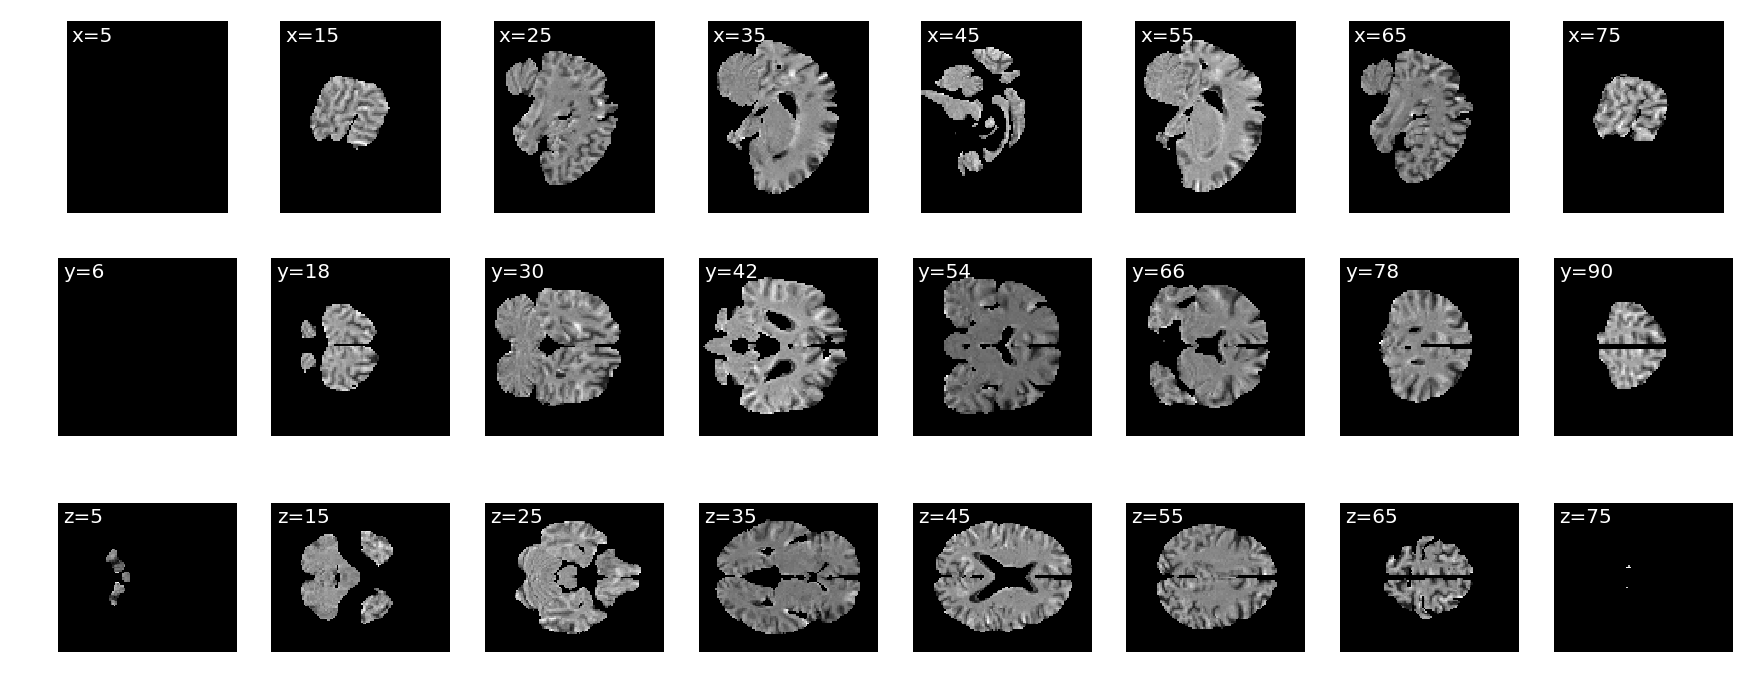

In [18]:
plot_slices(X_train_torch[0, 0])

In [19]:
X_train.mean(), X_train.std()

(0.28862849, 0.72520882)

In [20]:
y_train_torch[:10]


    0
    0
    1
    0
    1
    1
    1
    0
    1
    0
[torch.FloatTensor of size 10x1]

### Using torchsample

In [21]:
from torchsample.modules import ModuleTrainer
from torchsample.metrics import BinaryAccuracy
from torchsample.callbacks import TQDM

/Users/d068730/Projects/torchsample/torchsample/modules/_utils.py:8: UserWarning: inspect.signature not available... you should upgrade to Python 3.x
  warnings.warn('inspect.signature not available... '


In [22]:
net = ClassificationModel3D()

In [23]:
if torch.cuda.is_available():
    net = net.cuda()
    cuda_device = torch.cuda.current_device()
    print('Moved network to GPU')
else:
    cuda_device = -1
    print('GPU not available')

GPU not available


In [24]:
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)
loss_function = nn.BCEWithLogitsLoss()

In [25]:
trainer = ModuleTrainer(net)
# TODO: Implement a metric BinaryAccuracyWithLogits to account for the BCEWithLogitsLoss function.
trainer.compile(loss=loss_function, optimizer=optimizer, metrics=[BinaryAccuracy()], callbacks=[])

In [26]:
trainer.summary([1, 91, 109, 91])

OrderedDict([('Conv3d-1',
              OrderedDict([('input_shape', [-1, 1L, 91L, 109L, 91L]),
                           ('output_shape', [-1, 64L, 89L, 107L, 89L]),
                           ('trainable', True),
                           ('nb_params', 1792)])),
             ('Conv3d-2',
              OrderedDict([('input_shape', [-1, 64L, 29L, 35L, 29L]),
                           ('output_shape', [-1, 64L, 27L, 33L, 27L]),
                           ('trainable', True),
                           ('nb_params', 110656)])),
             ('Conv3d-3',
              OrderedDict([('input_shape', [-1, 64L, 9L, 11L, 9L]),
                           ('output_shape', [-1, 64L, 7L, 9L, 7L]),
                           ('trainable', True),
                           ('nb_params', 110656)])),
             ('Conv3d-4',
              OrderedDict([('input_shape', [-1, 64L, 7L, 9L, 7L]),
                           ('output_shape', [-1, 64L, 5L, 7L, 5L]),
                           ('trainable', 

In [27]:
# TODO: Make TQDM show running average, not the current batch value.
# TODO: Record/show metrics for validation data.
trainer.fit(X_train_torch, y_train_torch, 
            val_data=(X_val_torch, y_val_torch),
            num_epoch=40, 
            batch_size=2,  # 2
            shuffle=True,
            verbose=1,
            cuda_device=cuda_device)

Epoch 1/40: : 31 batches [02:19,  9.32s/ batches, acc_metric=3.2570, loss=34.5414]                 
Epoch 2/40:   3%|▎         | 1/30 [00:00<00:05,  5.57 batches/s]

New epoch logs:
{'val_acc_metric': 44.44444444444444, 'val_loss': 0.6449156105518341}
Updated epoch metrics:
{'acc_metric': [3.257024741226352], 'loss': [34.54143935563043], 'val_acc_metric': [44.44444444444444], 'val_loss': [0.6449156105518341]}


Epoch 2/40: : 31 batches [02:17,  9.31s/ batches, acc_metric=43.9671, loss=0.6996]                
Epoch 3/40:   3%|▎         | 1/30 [00:00<00:05,  5.61 batches/s]

New epoch logs:
{'val_acc_metric': 0.0, 'val_loss': 1.1402995944023133}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065], 'loss': [34.54143935563043, 0.6995782812436422], 'val_acc_metric': [44.44444444444444, 0.0], 'val_loss': [0.6449156105518341, 1.1402995944023133]}


Epoch 3/40: : 31 batches [02:13,  9.23s/ batches, acc_metric=29.7974, loss=0.7629]                
Epoch 4/40:   3%|▎         | 1/30 [00:00<00:05,  5.64 batches/s]

New epoch logs:
{'val_acc_metric': 16.666666666666668, 'val_loss': 0.6010510236024856}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065, 29.797416333186103], 'loss': [34.54143935563043, 0.6995782812436422, 0.7628730525573094], 'val_acc_metric': [44.44444444444444, 0.0, 16.666666666666668], 'val_loss': [0.6449156105518341, 1.1402995944023133, 0.6010510236024856]}


Epoch 4/40: : 31 batches [02:13,  9.34s/ batches, acc_metric=33.8576, loss=0.6426]                
Epoch 5/40:   3%|▎         | 1/30 [00:00<00:05,  5.57 batches/s]

New epoch logs:
{'val_acc_metric': 44.44444444444444, 'val_loss': 0.8633267790079117}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065, 29.797416333186103, 33.857649299896494], 'loss': [34.54143935563043, 0.6995782812436422, 0.7628730525573094, 0.6426204492648443], 'val_acc_metric': [44.44444444444444, 0.0, 16.666666666666668, 44.44444444444444], 'val_loss': [0.6449156105518341, 1.1402995944023133, 0.6010510236024856, 0.8633267790079117]}


Epoch 5/40: : 31 batches [02:26, 10.73s/ batches, acc_metric=35.9544, loss=0.6659]                
Epoch 6/40:   3%|▎         | 1/30 [00:00<00:04,  7.06 batches/s]

New epoch logs:
{'val_acc_metric': 61.111111111111114, 'val_loss': 0.6463161200284958}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065, 29.797416333186103, 33.857649299896494, 35.954382124060274], 'loss': [34.54143935563043, 0.6995782812436422, 0.7628730525573094, 0.6426204492648443, 0.6658931021889051], 'val_acc_metric': [44.44444444444444, 0.0, 16.666666666666668, 44.44444444444444, 61.111111111111114], 'val_loss': [0.6449156105518341, 1.1402995944023133, 0.6010510236024856, 0.8633267790079117, 0.6463161200284958]}


Epoch 6/40: : 31 batches [02:25,  9.73s/ batches, acc_metric=60.9697, loss=0.6371]                
Epoch 7/40:   3%|▎         | 1/30 [00:00<00:03,  7.37 batches/s]

New epoch logs:
{'val_acc_metric': 50.0, 'val_loss': 0.6006117552518845}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065, 29.797416333186103, 33.857649299896494, 35.954382124060274, 60.96966170500687], 'loss': [34.54143935563043, 0.6995782812436422, 0.7628730525573094, 0.6426204492648443, 0.6658931021889051, 0.6371247823039692], 'val_acc_metric': [44.44444444444444, 0.0, 16.666666666666668, 44.44444444444444, 61.111111111111114, 50.0], 'val_loss': [0.6449156105518341, 1.1402995944023133, 0.6010510236024856, 0.8633267790079117, 0.6463161200284958, 0.6006117552518845]}


Epoch 7/40: : 31 batches [02:25,  9.37s/ batches, acc_metric=42.2403, loss=0.6125]                
Epoch 8/40:   3%|▎         | 1/30 [00:00<00:03,  7.62 batches/s]

New epoch logs:
{'val_acc_metric': 16.666666666666668, 'val_loss': 0.5726736009120941}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065, 29.797416333186103, 33.857649299896494, 35.954382124060274, 60.96966170500687, 42.24033003401998], 'loss': [34.54143935563043, 0.6995782812436422, 0.7628730525573094, 0.6426204492648443, 0.6658931021889051, 0.6371247823039692, 0.6124849734206994], 'val_acc_metric': [44.44444444444444, 0.0, 16.666666666666668, 44.44444444444444, 61.111111111111114, 50.0, 16.666666666666668], 'val_loss': [0.6449156105518341, 1.1402995944023133, 0.6010510236024856, 0.8633267790079117, 0.6463161200284958, 0.6006117552518845, 0.5726736009120941]}


Epoch 8/40: : 31 batches [02:14,  9.32s/ batches, acc_metric=43.9887, loss=0.6229]                
Epoch 9/40:   3%|▎         | 1/30 [00:00<00:04,  6.38 batches/s]

New epoch logs:
{'val_acc_metric': 61.111111111111114, 'val_loss': 0.6920731663703918}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065, 29.797416333186103, 33.857649299896494, 35.954382124060274, 60.96966170500687, 42.24033003401998, 43.98866262609359], 'loss': [34.54143935563043, 0.6995782812436422, 0.7628730525573094, 0.6426204492648443, 0.6658931021889051, 0.6371247823039692, 0.6124849734206994, 0.6228778953353564], 'val_acc_metric': [44.44444444444444, 0.0, 16.666666666666668, 44.44444444444444, 61.111111111111114, 50.0, 16.666666666666668, 61.111111111111114], 'val_loss': [0.6449156105518341, 1.1402995944023133, 0.6010510236024856, 0.8633267790079117, 0.6463161200284958, 0.6006117552518845, 0.5726736009120941, 0.6920731663703918]}


Epoch 9/40: : 31 batches [02:14,  9.34s/ batches, acc_metric=56.2128, loss=0.6115]                
Epoch 10/40:   3%|▎         | 1/30 [00:00<00:05,  5.52 batches/s]

New epoch logs:
{'val_acc_metric': 22.22222222222222, 'val_loss': 0.5506933391094208}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065, 29.797416333186103, 33.857649299896494, 35.954382124060274, 60.96966170500687, 42.24033003401998, 43.98866262609359, 56.212815110673155], 'loss': [34.54143935563043, 0.6995782812436422, 0.7628730525573094, 0.6426204492648443, 0.6658931021889051, 0.6371247823039692, 0.6124849734206994, 0.6228778953353564, 0.6115200559298197], 'val_acc_metric': [44.44444444444444, 0.0, 16.666666666666668, 44.44444444444444, 61.111111111111114, 50.0, 16.666666666666668, 61.111111111111114, 22.22222222222222], 'val_loss': [0.6449156105518341, 1.1402995944023133, 0.6010510236024856, 0.8633267790079117, 0.6463161200284958, 0.6006117552518845, 0.5726736009120941, 0.6920731663703918, 0.5506933391094208]}


Epoch 10/40: : 31 batches [02:14,  9.43s/ batches, acc_metric=32.6879, loss=0.6181]                
Epoch 11/40:   3%|▎         | 1/30 [00:00<00:03,  7.52 batches/s]

New epoch logs:
{'val_acc_metric': 16.666666666666668, 'val_loss': 0.5481741815805435}
Updated epoch metrics:
{'acc_metric': [3.257024741226352, 43.96710283523065, 29.797416333186103, 33.857649299896494, 35.954382124060274, 60.96966170500687, 42.24033003401998, 43.98866262609359, 56.212815110673155, 32.687874796283324], 'loss': [34.54143935563043, 0.6995782812436422, 0.7628730525573094, 0.6426204492648443, 0.6658931021889051, 0.6371247823039692, 0.6124849734206994, 0.6228778953353564, 0.6115200559298197, 0.6180990998943646], 'val_acc_metric': [44.44444444444444, 0.0, 16.666666666666668, 44.44444444444444, 61.111111111111114, 50.0, 16.666666666666668, 61.111111111111114, 22.22222222222222, 16.666666666666668], 'val_loss': [0.6449156105518341, 1.1402995944023133, 0.6010510236024856, 0.8633267790079117, 0.6463161200284958, 0.6006117552518845, 0.5726736009120941, 0.6920731663703918, 0.5506933391094208, 0.5481741815805435]}


Epoch 11/40: 100%|██████████| 30/30 [01:56<00:00,  3.89s/ batches, acc_metric=28.1175, loss=0.6293]


KeyboardInterrupt: 

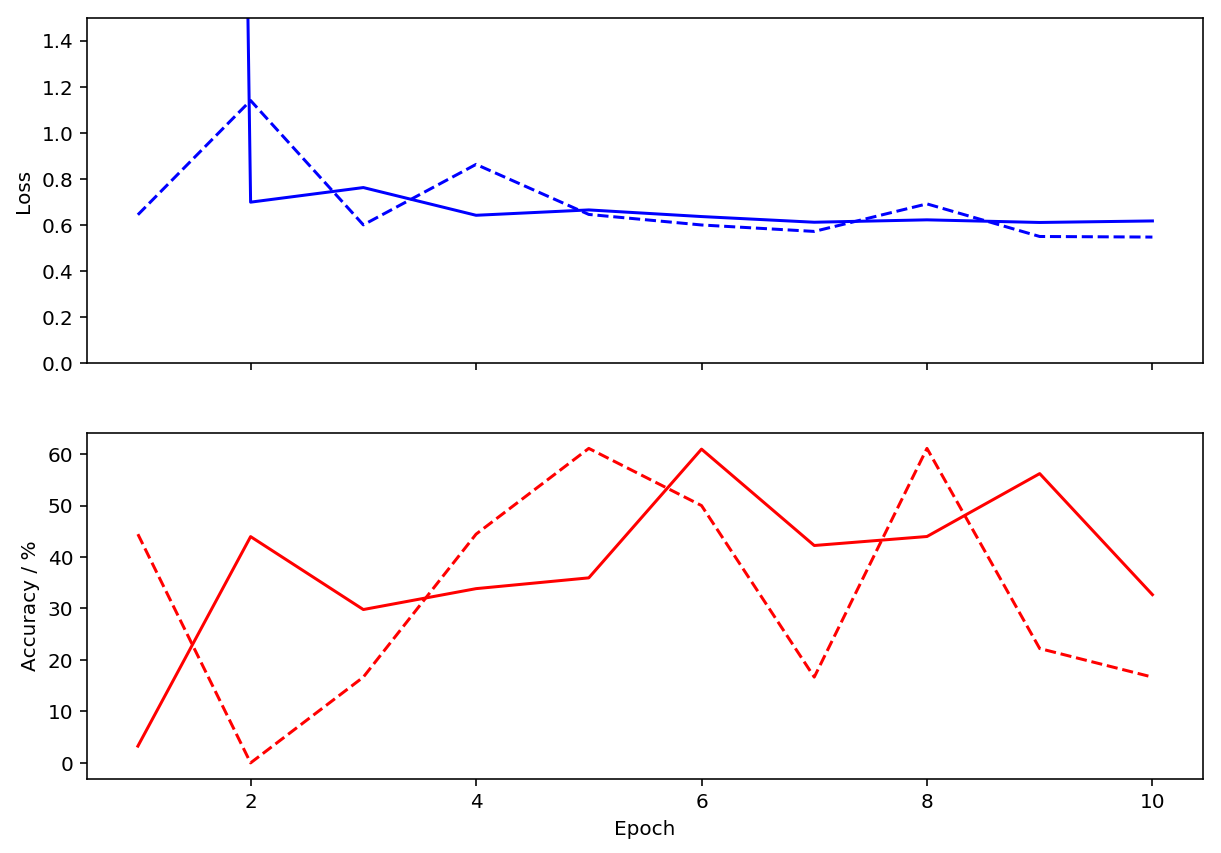

In [33]:
def plot_learning_curve(history):
    
    fig, axes = plt.subplots(2, sharex=True, figsize=(10, 7))
    
    epochs = range(1, len(history['loss'])+1)
    
    plt.sca(axes[0])
    plt.plot(epochs, history['loss'], 'b-')
    plt.plot(epochs, history['val_loss'], 'b--')
    plt.ylabel('Loss')
    plt.ylim(0, 1.5)
    
    plt.sca(axes[1])
    plt.plot(epochs, history['acc_metric'], 'r-')
    plt.plot(epochs, history['val_acc_metric'], 'r--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy / %')
    
plot_learning_curve(trainer.history)

In [ ]:
# TODO: Try out the torchsample.datasets.FolderDataset together with nifti images, and possibly transforms. 

In [176]:
#torch.save(net, 'data/adni-model-pytorch-40epochs.p')

In [34]:
net.eval()

ClassificationModel3D(
  (Conv_1): Conv3d (1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_2): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_3): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d (64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (dense_1): Linear(in_features=128, out_features=1)
)

In [36]:
trainer.predict(X_test_torch, cuda_device=cuda_device)

UnboundLocalError: local variable 'prediction_lists' referenced before assignment

In [38]:
#pred_train_torch = net(Variable(X_train_torch, requires_grad=False)).data.numpy()
#pred_val_torch = net(Variable(X_val_torch, requires_grad=False)).data.numpy()
pred_test_torch = F.sigmoid(net(Variable(X_test_torch, requires_grad=False))).data.numpy()

In [43]:
pred_test_torch

array([[ 0.25231445],
       [ 0.17962132],
       [ 0.41492382],
       [ 0.64743561],
       [ 0.00677245],
       [ 0.48859993],
       [ 0.16476916],
       [ 0.29690835],
       [ 0.37335753],
       [ 0.34150726],
       [ 0.43158504],
       [ 0.62240785],
       [ 0.36389846],
       [ 0.40703711],
       [ 0.36962903],
       [ 0.64552373],
       [ 0.23357242],
       [ 0.58074987],
       [ 0.17252098]], dtype=float32)

In [44]:
y_test

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]], dtype=int8)

In [41]:
#np.mean(pred_train_torch.round() == y_train), np.mean(pred_val_torch.round() == y_val), 
np.mean(pred_test_torch.round() == y_test)

0.78947368421052633

### Using a Dataset object

In [31]:
from torch.utils.data import TensorDataset

In [32]:
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=1)

In [48]:
net = ClassificationModel3D()
loss_function = nn.BCELoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

In [50]:
if torch.cuda.is_available():
    net = net.cuda()
    print('Moved network to GPU')
else:
    print('GPU not available')

Moved network to GPU


In [44]:
epochs = 40

for epoch in range(epochs):
    running_loss = 0
    
    for batch, (inputs, labels) in enumerate(train_loader):
        inputs, labels = Variable(inputs), Variable(labels)
        
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        n = 10
        if batch % n == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch + 1, running_loss / n))
            running_loss = 0.0

[1,     1] loss: 0.073
[1,    11] loss: 8.289
[1,    21] loss: 6.908
[2,     1] loss: 2.763
[2,    11] loss: 12.434
[2,    21] loss: 13.816
[3,     1] loss: 0.000
[3,    11] loss: 11.052
[3,    21] loss: 16.579
[4,     1] loss: 1.382
[4,    11] loss: 6.908
[4,    21] loss: 13.816
[5,     1] loss: 2.763
[5,    11] loss: 12.434
[5,    21] loss: 15.197
[6,     1] loss: 0.000
[6,    11] loss: 15.197
[6,    21] loss: 17.960
[7,     1] loss: 0.000
[7,    11] loss: 6.908
[7,    21] loss: 16.579
[8,     1] loss: 2.763
[8,    11] loss: 9.671
[8,    21] loss: 13.816
[9,     1] loss: 1.382
[9,    11] loss: 11.052
[9,    21] loss: 13.816
[10,     1] loss: 2.763
[10,    11] loss: 11.052
[10,    21] loss: 13.816
[11,     1] loss: 2.763
[11,    11] loss: 9.671
[11,    21] loss: 13.816
[12,     1] loss: 1.382
[12,    11] loss: 15.197
[12,    21] loss: 11.052
[13,     1] loss: 0.000
[13,    11] loss: 13.816
[13,    21] loss: 15.197
[14,     1] loss: 1.382
[14,    11] loss: 11.052
[14,    21] loss: 11.0

In [10]:
# TODO: Add transforms.
class ADNIDataset(Dataset):
    
    def __init__(self, root_dir, mask=None, remove_nan=True):
        self.root_dir = root_dir
        self.filenames = os.listdir(self.root_dir).filter(lambda filename: filename.endswith('nii'))
        self.mask = mask
        self.remove_nan = remove_nan
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        struct_arr = load_nifti(os.path.join(self.root_dir, self.filenames[idx]), mask=mask, remove_nan=self.remove_nan)
        # TODO: How to do preprocessing if we don't know the mean and std before? (This is impossible for large datasets)
        #       Maybe calculate an approximate value beforehand and just give it as a parameter here (c.f. ImageNet examples).
        label = 1 if filename.startswith('AD') else 0
        return struct_arr, label

In [ ]:


train_loader = DataLoader(dset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=4
                         # pin_memory=True # CUDA only
                         )

## Apply sensitivity analysis to ADNI model

In [576]:
# TODO: These are adapted from above in order to deal with binary output instead of softmax. Generalize this.

def sensitivity_analysis(model, image_tensor, target=None, postprocess='abs', output_mode=None):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    if output_mode not in [None, 'binary', 'categorical']:
        raise ValueError("output_mode must be None, 'binary' or 'categorical'")
    if postprocess not in [None, 'abs', 'square']:
        raise ValueError("postprocess must be None, 'abs' or 'sqaure'")
    
    # Forward pass.
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    model.eval()
    output = model(X)
    
    # Backward pass.
    model.zero_grad()
    if output_mode is None:
        output_mode = 'binary' if output.size(1) == 1 else 'categorical'
    if output_mode == 'binary':  # binary output
        # TODO: Does it make sense to always use one here as the output gradient? 
        #       (This is similar to using one-hot below.)
        print('Image was classified as:', output.data.numpy()[0, 0].round())
        output.backward(gradient=torch.ones(output.size()))
    elif output_mode == 'categorical':  # categorical output
        output_class = output.max(1)[1].data.numpy()[0]
        print('Image was classified as:', output_class)
        # TODO: Check if setting to one hot makes sense here.
        one_hot_output = torch.zeros(output.size())
        if target is None:
            one_hot_output[0, output_class] = 1
        else:
            one_hot_output[0, target] = 1
        output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    # Postprocess the relevance map.
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
        
        
def guided_backprop(model, image_tensor, target=None, postprocess='abs', output_mode=None):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ELU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        #for pos, module in model.features._modules.items():
        for module in model.children():
            if isinstance(module, nn.ELU):
                print('Registered hook for layer:', module)
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target=target, postprocess=postprocess, output_mode=output_mode)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        print('Removing {} hook(s)'.format(len(hook_handles)))
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

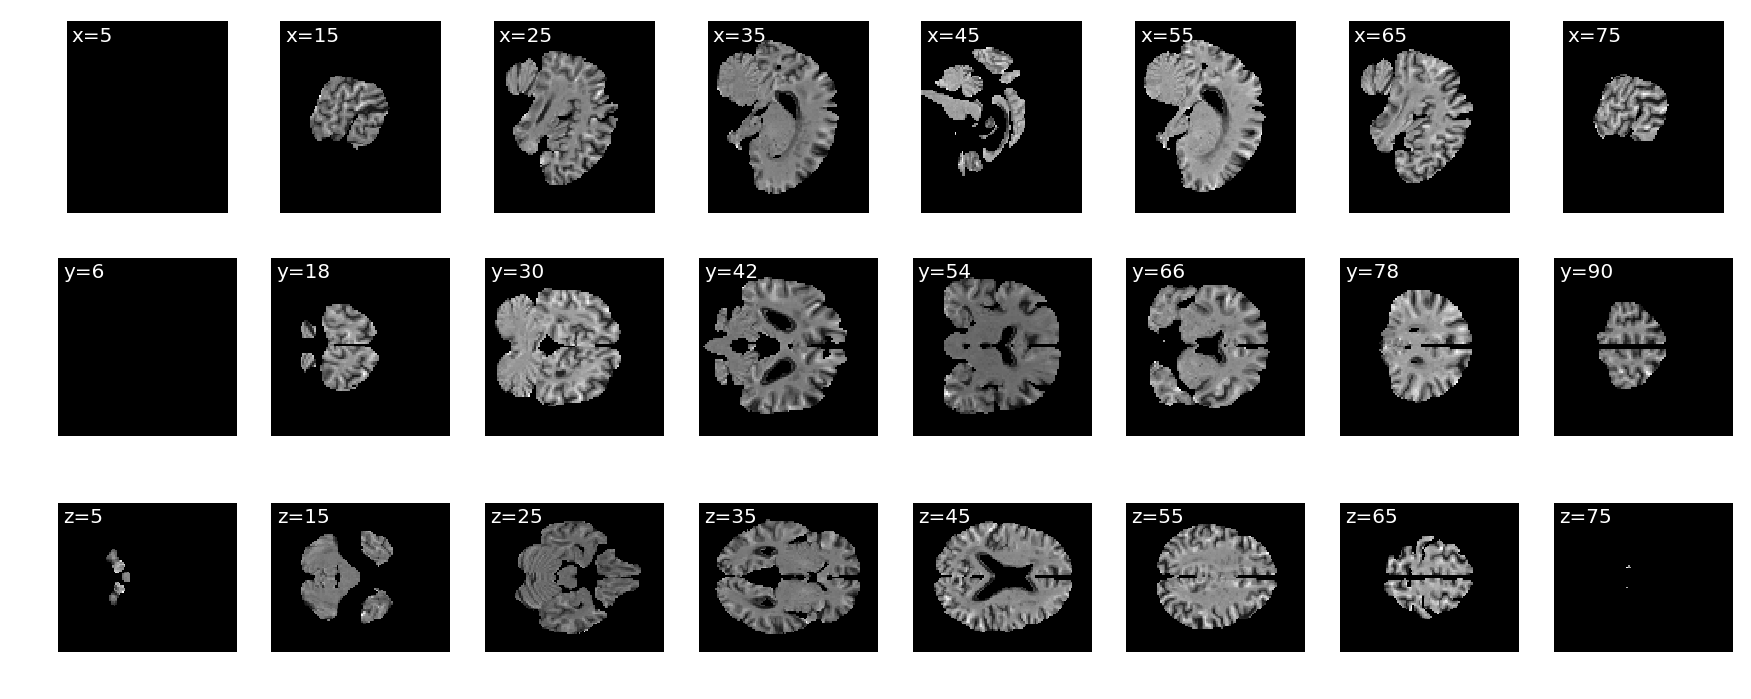

In [577]:
plot_slices(X_test_torch.numpy()[0, 0])

In [578]:
relevance_map = sensitivity_analysis(pytorch_model, X_test_torch[0])
relevance_map.shape

Image was classified as: 1.0


(1, 91, 109, 91)

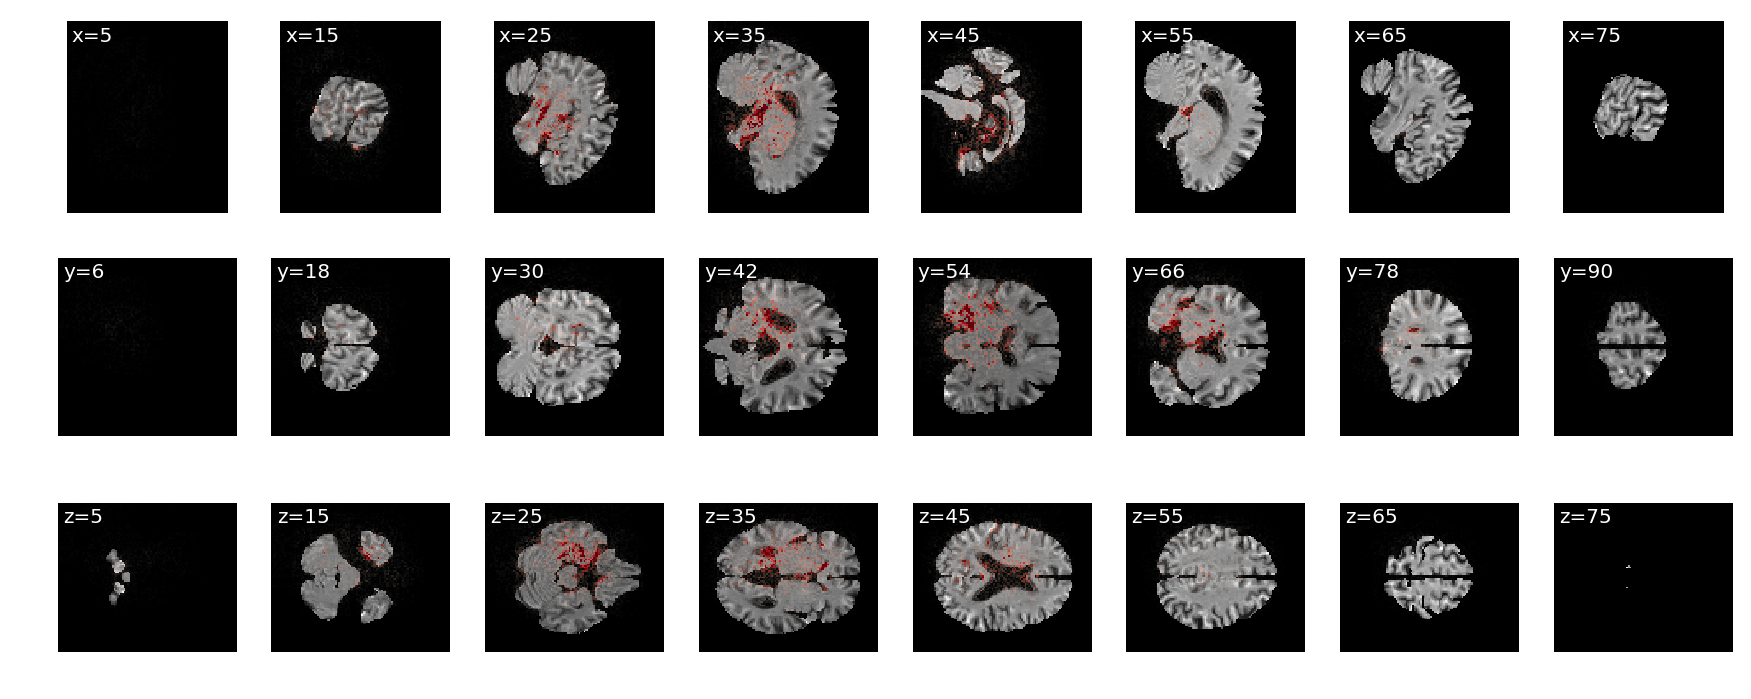

In [580]:
plot_slices(X_test_torch.numpy()[0, 0], overlay=relevance_map[0], overlay_vmax=np.percentile(relevance_map, 99.9))

In [581]:
relevance_map = guided_backprop(pytorch_model, X_test_torch[0])
relevance_map.shape

Registered hook for layer: ELU(alpha=1.0)
Image was classified as: 1.0
Removing 1 hook(s)


(1, 91, 109, 91)

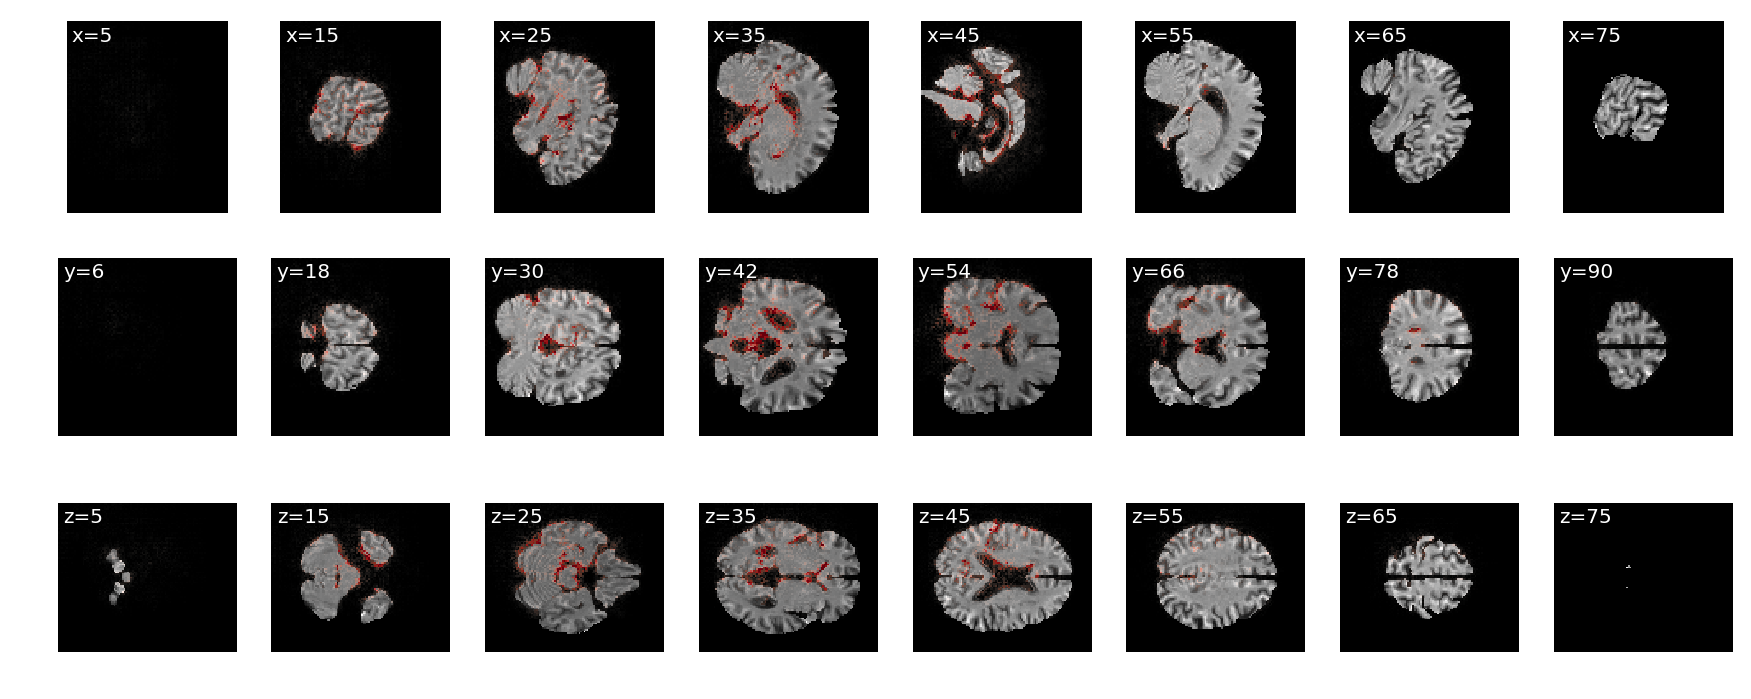

In [583]:
plot_slices(X_test_torch.numpy()[0, 0], overlay=relevance_map[0], overlay_vmax=np.percentile(relevance_map, 99.9))

In [595]:
from ipywidgets import interact

struct_arr = X_test_torch.numpy()[0, 0]
overlay=relevance_map[0]
overlay_vmin = 0
overlay_vmax=np.percentile(relevance_map, 99.9)


def f(x):
    plt.axis('off')
    plt.imshow(struct_arr[x, :, :], cmap='gray', interpolation=None)
    #plt.text(0.03, 0.97, '{}={}'.format('x', x), color='white', horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)
    if overlay is not None:
        plt.imshow(overlay[x, :, :], cmap=alpha_cmap, vmin=overlay_vmin, vmax=overlay_vmax, interpolation=None)
    plt.show()
    
interact(f, x=(0, struct_arr.shape[0]-1))

<function __main__.f>

## Traverse pytorch model

In [137]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    #dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                print('Tensor:', str(id(var)), size_to_str(var.size()))
                #dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
                pass
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                print('Variable: ', str(id(var)), node_name)
                #dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                print('Whatever: ', str(id(var)), str(type(var).__name__))
                #dot.node(str(id(var)), str(type(var).__name__))
                pass
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        #dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    #dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    #return dot

In [138]:
make_dot(out)

Whatever:  4548426488 SigmoidBackward
Whatever:  4548426240 AddmmBackward
Variable:  4557421072 
 (1)
Whatever:  4548425744 ViewBackward
Whatever:  4548425496 MaxPool3dBackward
Whatever:  4548425248 ELUBackward
Whatever:  4551987600 ConvNdBackward
Whatever:  4548425000 ELUBackward
Whatever:  4551987344 ConvNdBackward
Whatever:  4548424752 MaxPool3dBackward
Whatever:  4548424504 ELUBackward
Whatever:  4551990608 ConvNdBackward
Whatever:  4548424256 MaxPool3dBackward
Whatever:  4548424008 ELUBackward
Whatever:  4551987984 ConvNdBackward
Variable:  4551989392 
 (64, 1, 3, 3, 3)
Variable:  4551988944 
 (64)
Tensor: 4955330608 (1, 64, 89, 107, 89)
Tensor: 4559218664 (1, 64, 89, 107, 89)
Tensor: 4574505080 (1, 64, 89, 107, 89)
Tensor: 4574505512 (1, 64, 29, 35, 29)
Variable:  4551988496 
 (64, 64, 3, 3, 3)
Variable:  4551990928 
 (64)
Tensor: 4574504000 (1, 64, 27, 33, 27)
Tensor: 4574506016 (1, 64, 27, 33, 27)
Tensor: 4574503352 (1, 64, 27, 33, 27)
Tensor: 4574506304 (1, 64, 9, 11, 9)
Varia

In [158]:
def traverse(node, indent='  '):
    #if torch.is_tensor(node): print('tensor')
    if not hasattr(node, 'variable'):
        
        print(indent, node)
        if node is not None:
            for next_node_tuple in node.next_functions:
                traverse(next_node_tuple[0], indent+'  ')
        
        
traverse(out.grad_fn)

                               None


In [144]:
out.grad_fn.next_functions[0][0].grad_fn

AttributeError: 'AddmmBackward' object has no attribute 'grad_fn'